In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
from moviepy.editor import VideoFileClip
import time
#qt for configurable window
%matplotlib inline

In [36]:
objpoints = []
imgpoints = []
prevleftx = []
prevrightx = []
prevlefty = []
prevrighty = []

In [37]:
def drawTransformLines(binary_warped, minpix = 50):
    ############
    ## Code to calculate and draw line positions referenced from Project: Advanced Lane Finding, Pt. 33
    ############
    
    global prevleftx
    global prevrightx
    global prevlefty
    global prevrighty
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create output image to draw
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram, likely to be the lane line
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint + 200:]) + (midpoint + 200)

    # Choose slices to divide window into
    nwindows = 9
    
    # Set height of windows by dividing shape by chosen amount of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Find all non-zero pixels in image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Assign current position to base of histogram peaks
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows pixel found margin
    margin = 50
    
    # Create empty lists for storing lane indices
    left_lane_inds = []
    right_lane_inds = []

    # Loop through each window up to amount of windows
    
    for window in range(nwindows):
        # Identify window boundaries
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the current index
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & \
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & \
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append to lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
            
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
#   avgleftx, avglefty, avgrightx, avgrighty = averageLines(leftx,lefty,rightx,righty)
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        prevleftx = leftx
        prevlefty = lefty
    else:
        left_fit = np.polyfit(prevlefty, prevleftx, 2)
        
        
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        prevrightx = rightx
        prevrighty = righty
    else:
        right_fit = np.polyfit(prevrighty, prevrightx, 2)

        
#   left_fit = np.polyfit(avglefty, avgleftx, 2)
#   right_fit = np.polyfit(avgrighty, avgrightx, 2)

    
#   left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#   right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
   
    return out_img, left_fit, right_fit, ploty
       
    
    
def drawUntransformLines(warped,original,left_fitx,right_fitx,ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transform(color_warp, inverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    return result
    
    

def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist)
    return undist



def convertHSV(img, low, high, default = False):
    
    img = np.copy(img)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    colorbinary = np.zeros((img.shape[0], img.shape[1]))
    colorbinary[(hsv[:,:,0] >= low[0]) & (hsv[:,:,0] <= high[0]) & \
                (hsv[:,:,1] >= low[1]) & (hsv[:,:,1] <= high[1])  &  
                (hsv[:,:,2] >= low[2]) & (hsv[:,:,2] <= high[2])] = 1
    
    return colorbinary
    
    
    
def sobelx(img, sob_thresh = (0,255), kernel = 3):
    
    img = np.copy(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    abs_sob = np.absolute(sobel)
    bitsobel = np.uint8(255*abs_sob/np.max(abs_sob))
    sob_binary = np.zeros_like(bitsobel)
    sob_binary[(bitsobel >= sob_thresh[0]) & (bitsobel <= sob_thresh[1])] = 1
    
    return sob_binary
    
    
    
def transform(img,inverse = False):
        # Store image size 
        img_size = (img.shape[1],img.shape[0])
        
        # Define arbitrary source points based on straight_lines1.jpg
#         src = np.float32([[580,475],
#                           [700,475],
#                           [900,675],
#                           [380,675]])
        
#         # Define source points
#         dst = np.float32([[380,0],
#                           [900,0],
#                           [900,720],
#                           [380,720]])


        src = np.float32([[529.,466.],
                          [751.,466.],
                          [1218.,675.],
                          [62.,675.]])
    
        dst = np.float32([[139.,0.],
                          [1141.,0.],
                          [1141.,720.],
                          [139.,720.]])
        
        # Calculate perspective transform
        M = cv2.getPerspectiveTransform(src, dst)
        
        if inverse:
            # Calculate inverse transform
            M = cv2.getPerspectiveTransform(dst, src)
            
        # Warp perspective using either normal or inverse instructions
        warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warp
        
        
        
def curveAndOffset(img, ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    
    ym_per_pix = 30./720
    xm_per_pix = 3.7/700
    
    fit_cr_left = np.polyfit(ploty*ym_per_pix, left_fitx * xm_per_pix, 2)
    fit_cr_right = np.polyfit(ploty*ym_per_pix, right_fitx * xm_per_pix, 2)
    
    curveLeft = ((1 + (2*fit_cr_left[0]*y_eval*ym_per_pix + fit_cr_left[1])**2)**1.5) / np.absolute(2*fit_cr_left[0])
    curveRight = ((1 + (2*fit_cr_right[0]*y_eval*ym_per_pix + fit_cr_right[1])**2)**1.5) / np.absolute(2*fit_cr_right[0])
    
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    offset = np.abs(lane_center - img.shape[1]/2) * xm_per_pix

    return curveLeft, curveRight, offset



def readinCalibrate():
    #Read in chessboard images for camera calibration
    #X = 9
    #Y = 6
    #9x6
    img = glob.glob('camera_cal/calibration*.jpg')

    global objpoints
    global imgpoints

    objp = np.zeros((9*6,3), np.float32) #9x6, 3 coord: x,y,z
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for i in img:
        img = mpimg.imread(i)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return objpoints, imgpoints



def videopipeline(img):
    global objpoints
    global imgpoints
    
    undistorted = undistort(img, objpoints, imgpoints)
    
    yellowlow = np.array([10,100,90])
    yellowhigh = np.array([22,220,255])
    whitelow = np.array([20,0,180])
    whitehigh = np.array([255,80,255])

    hsvyellow = convertHSV(undistorted, yellowlow, yellowhigh)
    hsvwhite = convertHSV(undistorted, whitelow, yellowhigh)

    sobel = sobelx(undistorted, (30,100), kernel = 7)
    
    combo = np.zeros_like(sobel)
    combo[(sobel == 1) | (hsvyellow == 1) | (hsvwhite == 1)] = 1 
    
    transf = transform(combo)
    out,left_fit,right_fit,ploty = drawTransformLines(transf)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    final = drawUntransformLines(combo,undistorted,left_fitx,right_fitx,ploty)
    L_curve, R_curve, offset = curveAndOffset(final, ploty, left_fitx, right_fitx)
    averageCurve = (R_curve + L_curve) / 2 
    curvString = "Average Curvature: " + "~ %.3f m" % averageCurve
    midString = "Dist. From Center: " + "~ %.2f m" % offset
    
    cv2.putText(final,curvString, org = (75,75), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.2, color = (255,0,255), \
           thickness = 5)
    cv2.putText(final,midString, org = (75,120), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.2, color = (255,0,255), \
           thickness = 5)
    
    return final

In [38]:
readinCalibrate()

print("Calibration images successfully read in.")

Calibration images successfully read in.


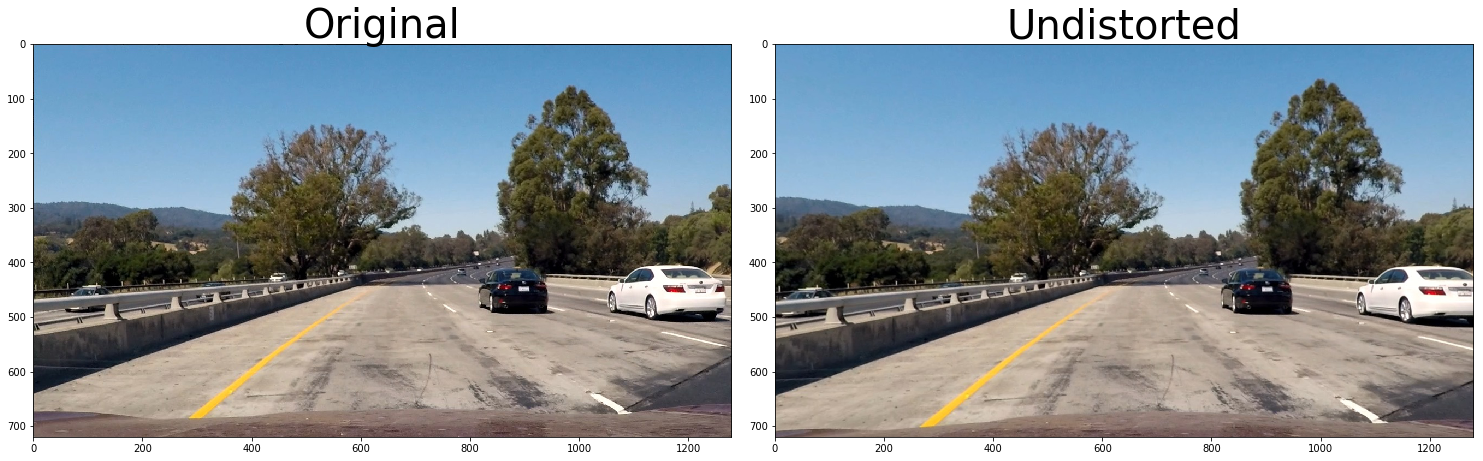

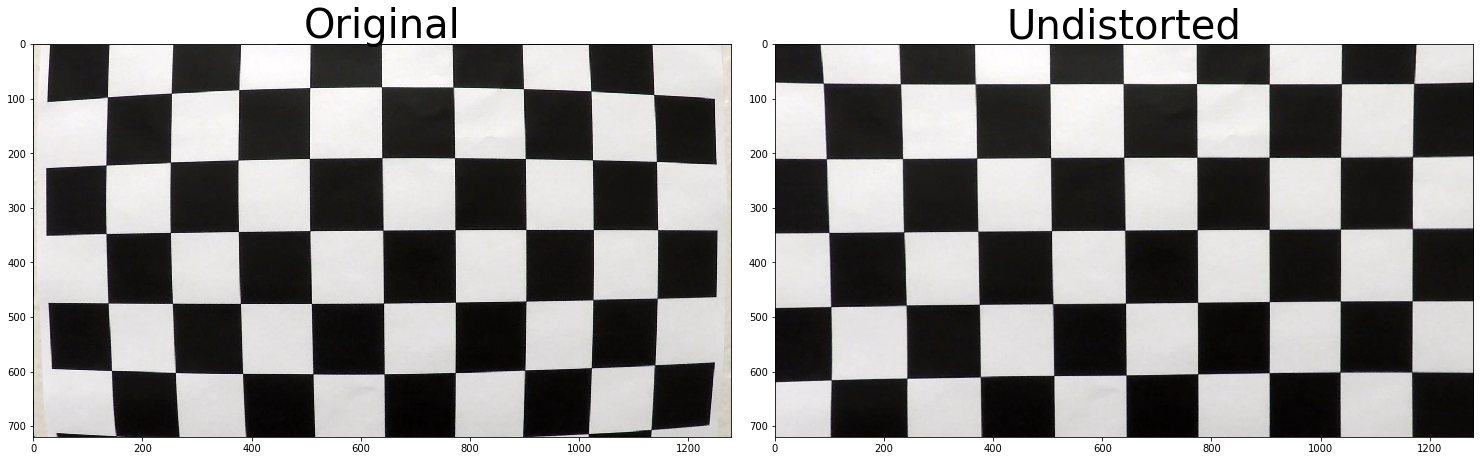

In [39]:
original = mpimg.imread('test_images/test1.jpg')
checkerorig = mpimg.imread('camera_cal/calibration1.jpg')
picundis = undistort(original, objpoints, imgpoints)
checkundis = undistort(checkerorig, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(original)
ax1.set_title('Original', fontsize=40)

ax2.imshow(picundis)
ax2.set_title('Undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f2, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
f2.tight_layout()

ax1.imshow(checkerorig)
ax1.set_title('Original', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax2.imshow(checkundis)
ax2.set_title('Undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

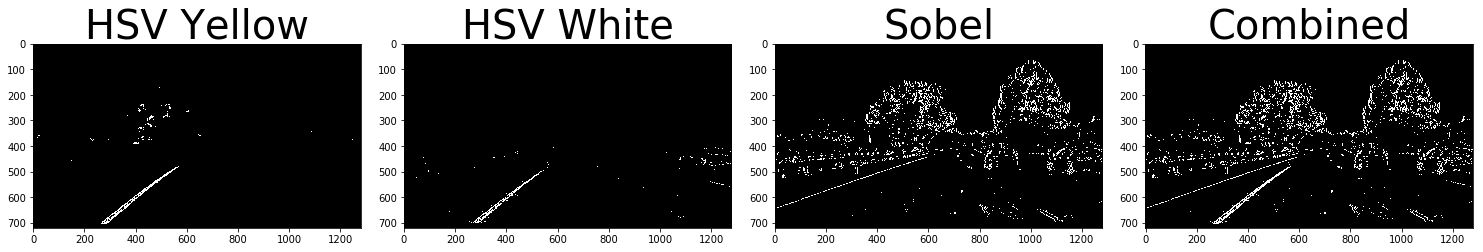

In [40]:
img = mpimg.imread('test_images/test1.jpg')
imgnew = undistort(img, objpoints, imgpoints)

# (140,255), sob_thresh = (15,80))

yellowlow = np.array([10,100,90])
yellowhigh = np.array([22,220,255])
whitelow = np.array([20,0,180])
whitehigh = np.array([255,80,255])

hsvyellow = convertHSV(imgnew, yellowlow, yellowhigh)
hsvwhite = convertHSV(imgnew, whitelow, yellowhigh)

sobel = sobelx(imgnew, (30,100), kernel = 7)

combo = np.zeros_like(sobel)
combo[(sobel == 1) | (hsvyellow == 1) | (hsvwhite == 1)] = 1 


f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 10))
f.tight_layout()

ax1.imshow(hsvyellow, cmap = 'gray')
ax1.set_title('HSV Yellow', fontsize=40)

ax2.imshow(hsvwhite, cmap = 'gray')
ax2.set_title('HSV White', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(sobel, cmap = 'gray')
ax3.set_title('Sobel', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax4.imshow(combo, cmap = 'gray')
ax4.set_title('Combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

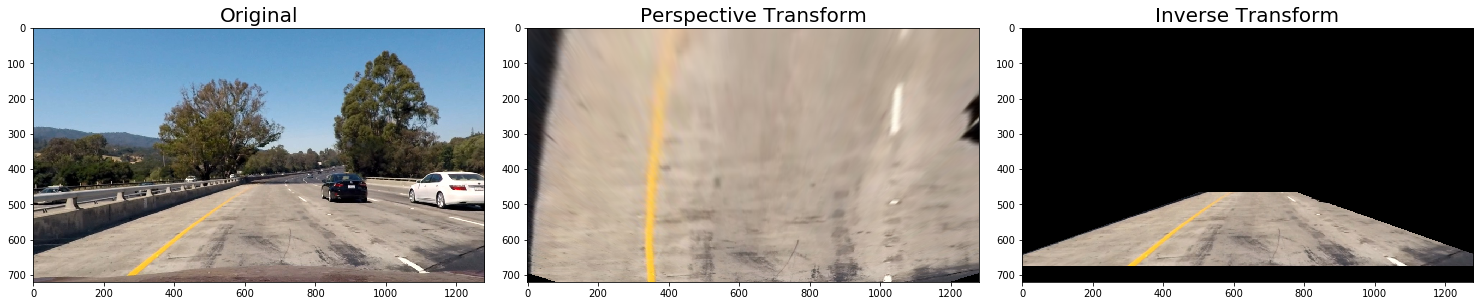

In [41]:
img = mpimg.imread('test_images/test1.jpg')

undis = undistort(img,objpoints,imgpoints)
transf = transform(undis)
transf2 = transform(transf,inverse = True)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 10))
f.tight_layout()
ax1.imshow(undis)
ax1.set_title('Original', fontsize=20)

ax2.imshow(transf)
ax2.set_title('Perspective Transform', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(transf2)
ax3.set_title('Inverse Transform', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# pts = np.array([[560,470],[730,470],[1080,680],[225,680]], np.int32)
# pts = pts.reshape((-1,1,2))
# cv2.polylines(undis,[pts],True,(255,0,0),thickness = 5)
# plt.imshow(undis)

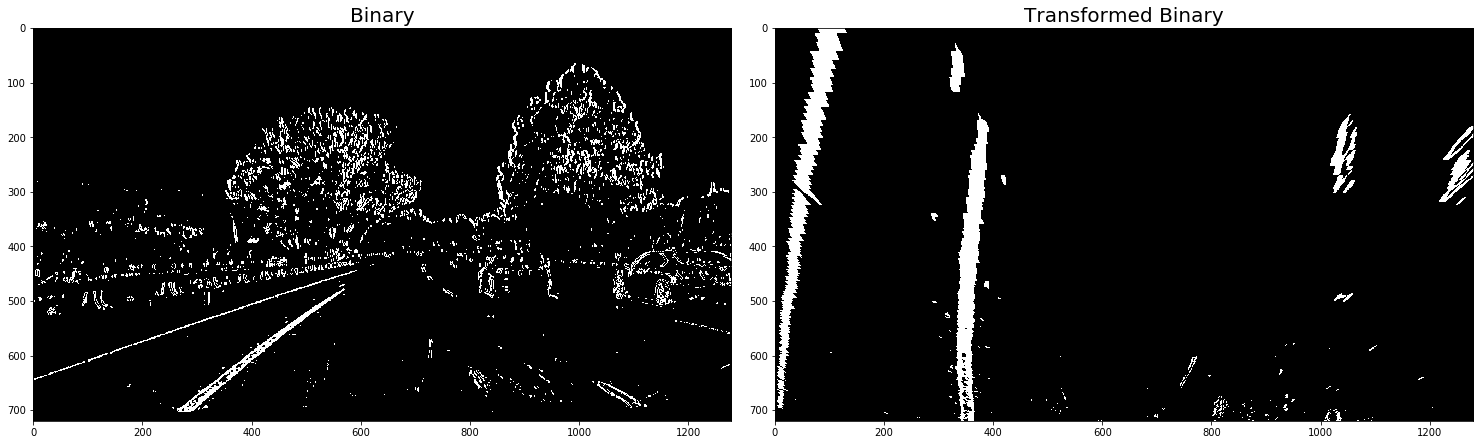

In [42]:
trans = transform(combo)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(combo, cmap = 'gray')
ax1.set_title('Binary', fontsize=20)

ax2.imshow(trans, cmap = 'gray')
ax2.set_title('Transformed Binary', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Left X: 356
Right X: 1030


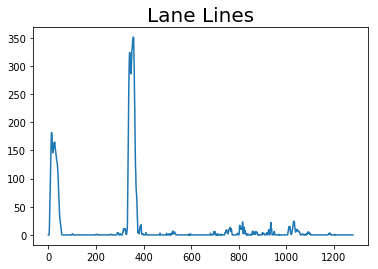

In [43]:
hist = np.sum(trans[trans.shape[0]//2:,:], axis=0)
plt.plot(hist)
plt.title("Lane Lines", fontsize = 20)

midpoint = np.int(hist.shape[0]/2)
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint + 200:]) + (midpoint + 200)
print("Left X:" , leftx_base)
print("Right X:" , rightx_base)

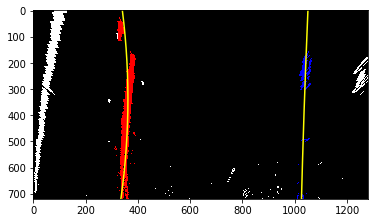

In [44]:
out,left_fit,right_fit,ploty = drawTransformLines(trans)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

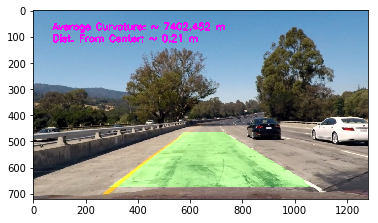

In [46]:
# drawUntransformLines(warped,original,left_fitx,right_fitx,ploty)


# Calculate radius of the curvature

newIm = drawUntransformLines(combo,undis,left_fitx,right_fitx,ploty)

L_curve, R_curve, offset = curveAndOffset(newIm, ploty, left_fitx, right_fitx)

averageCurve = (R_curve + L_curve) / 2 

curvString = "Average Curvature: " + "~ %.3f m" % averageCurve
midString = "Dist. From Center: " + "~ %.2f m" % offset

cv2.putText(newIm,curvString, org = (75,75), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.2, color = (255,0,255), \
           thickness = 5)
cv2.putText(newIm,midString, org = (75,120), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.2, color = (255,0,255), \
           thickness = 5)
plt.imshow(newIm)

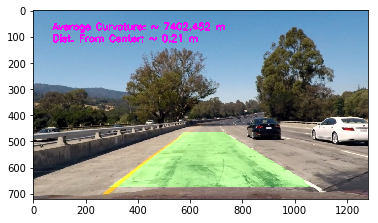

In [23]:
# Test full pipeline on one frame

test = mpimg.imread('test_images/test1.jpg')
test = videopipeline(test)
plt.imshow(test)

In [34]:
output = 'output_images/project_video_output2.mp4'

# .save_frame("frame.png", t=22.5)
# .subclip(23,25)

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(videopipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video output_images/project_video_output2.mp4
[MoviePy] Writing video output_images/project_video_output2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [30:02<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output2.mp4 

Wall time: 30min 3s
